# codecentric.AI Bootcamp - Convolutional Neural Networks

Hallo und herzlich Willkommen zurück beim **codecentric.AI Bootcamp**.

Heute geht es um die Frage: Wie lernen Computer eigentlich sehen? Also, wie lernen sie Bilder und Objekte auf Bildern zu erkennen?

Eine der gängigsten Methoden dafür sind sogenannten **Convolutional Neural Networks**. Dieses Notebook enthält Beispiele und Übungsaufgaben.

Eine theoretische Einführung in Convolutional Neural Networks gibt es in diesem [YouTube video](https://youtu.be/MWPohcMtFLo).

In [11]:
# lade Video
from IPython.display import IFrame    
IFrame('https://www.youtube.com/embed/MWPohcMtFLo', width=850, height=650)

Zu diesem Notebook gibt es ebenfalls ein [Video](https://youtu.be/Suq8jDIGoug), in dem ich euch durch dieses Beispiel durchführe.

In [12]:
# lade Video
from IPython.display import IFrame    
IFrame('https://www.youtube.com/embed/Suq8jDIGoug', width=850, height=650)

## Convolution Neural Networks

Convolutional Neural Nets werden meisten als **CNNs** oder **ConvNets** abgekürzt; sie sind ein spezieller Typ von neuronalen Netzen, bei denen das Lernen etwas anders funktioniert, als bei Multi-Layer Perceptronen.

Die Funktionsweise von CNNs kann man sich ein bisschen so vorstellen, wie das **rezeptive Feld von Fotorezeptoren** im menschlichen Auge. Rezeptive Felder im menschlichen Auge sind kleinere zusammenhängende Bereiche auf der Netzhaut, wo Gruppen von vielen Fotorezeptoren gemeinsam auf wenige Ganglienzellen wirken. Jede Ganglienzelle kann also von einer großen Gruppe an Rezeptonen stimuliert werden. Aus einem komplexen Input ensteht so ein komprimierter Output, der im Gehirn weiter verarbeitet wird.

Genauer lernen CNNs, indem sie verschiedene **Abstraktionsebenen** der möglichen Klassen finden. Das heißt, in den ersten versteckten Schichten des neuronalen Netzes werden meistens allgemeine Muster, wie Kanten erkannt. Je weiter wir in den versteckten Schichten Richtung Output kommen, desto spezifischer werden die erkannten Muster, z.B. Texturen, grobe Muster, einzelne Teile der Objekte auf den Bildern und letztendlich ganze Objekte.

Bei CNNs werden **Gruppen aus benachbarten Pixeln** betrachtet. In diesem Neuronalen Netz sind Neuronen zunächst nur mit den lokal entsprechenden Neuronen in den Folgeschichten verbunden; das bezeichnen wir als **"local connectivity"**. Dadurch kann das Netz effizient und relativ schnell den Kontext von Mustern und Objekten lernen und diese auch in anderen Postionen auf dem Bild erkennen. Konkret funktionert das mit sogenannten **Sliding Windows**, also Fenstern, die eine Gruppe von Pixeln betrachten und dabei von links oben nach rechts unten das Bild abscannen. Gelernt werden dabei dann auch keine Gewichte, sondern **Filter** oder **Kernel**.

Auf jedem Fenster des Sliding Windows wird nämlich nun eine bestimmte mathematische Operation durchgeführt, die sogenannte **Faltung** - oder auf Englisch: **Convolution**. Diese Faltung passiert für jedes Fenster des gesamten Bildes. Die Faltung passiert über das Multiplizieren der Pixelwerte in unserem Fenster mit einem sogenannten Filter. Dieser Filter ist nichts anderes als eine Matrix mit den selben Dimensionen des Sliding Windows. Je nachdem, welche Werte in einem Filter stehen, führt die Faltung zu einer bestimmten **Transformation** des Originalbildes.

## Bibliotheken

Zunächst laden wir die grundlegenden Pakete, die wir für die Vorbereitung der Daten benötigten. Dazu gehören

- **cv2**: OpenCV for image processing.
- **numpy**: NumPy ist das wichtigste Paket für maschinelles Lernen in Python, denn es bietet die nötigen Funktionen für die Arbeit mit Matrizen und n-dimensionalen Arrays, linearer Algebra, und mehr.
- **pandas**: pandas erleichtert das Arbeiten mit Daten in Python.
- **random**: for pseudo-random number generation.
- **matplotlib**: Zum Erstellen von Graphiken und Abbildungen aus unseren Daten nutzen wir matplotlib. Den zusätzlichen Befehl `matplotlib inline` geben wir in unserem Juypter Notebook mit, damit wir die generierten Plots unterhalb des Code-Chunks sehen können.

In [13]:
import cv2
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
%matplotlib inline

## Ein CNN mit Keras und TensorFlow trainieren

In dieser Lektion verwenden wir [**Keras** und TensorFlow](https://keras.io/) um ein CNN zu trainieren, das Bilder von verschiedenen Früchten erkennen kann.

Dafür laden wir zunächst die nötigen Funktionen aus dem `keras` Paket. Was diese im einzelnen bedeuten und tun, erkläre ich, wenn wir sie verwenden.

Per Default wird mit Keras das **TensorFlow backend für CPUs** verwendet.

In [14]:
# image processing
from keras.preprocessing import image as image_utils
from keras.preprocessing.image import img_to_array

# build your own nets
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from keras.optimizers import RMSprop
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU

### Daten

Die Daten (also die Bilder), die wir verwenden, sind von [Kaggle](https://www.kaggle.com/moltean/fruits/data) und zeigen verschiedene Früchte auf weißem Hintergrund (Copyright (c) 2017 Mihai Oltean, Horea Muresan, MIT License). Einen Teil dieser Früchte haben wir euch in den `data` Ordner gelegt, damit ihr direkt loslegen könnt. Diese Bilder sind in dem Ordner `fruits-360` gespeichert, der zwei Unterordner enthält: `Training` und `Test`. Beide Unterordner enthalten wieder Unterordner mit den Namen der einzelnen Früchte. Hier wollen wir die **Trainingsbilder** zu trainieren des CNNs verwenden und die Testbilder zum validieren. Entsprechend definieren wir die Pfade:

In [15]:
train_image_files_path = "/data/fruits-360/Training/"
valid_image_files_path = "/data/fruits-360/Test/"

Nun definieren wir noch eine Reihe von anderen Objekten und Hyperparametern. Das tun wir in einem Block direkt am Anfang, damit wir später, wenn wir etwas ändern möchten, nicht unser gesamtes Notebook durchsuchen müssen.

- `fruit_list`: Diese Liste enthält hier alle **Namen** der jeweiligen Unterordner in `Training` und `Test`. Wir werden diese Liste gleich zum einlesen der Bilder verwenden. Wir könnten hier auch nur einen Teil der Ordner verwenden.
- `output_n`: Anzahl der **Klassen** (also der zu klassifizierenden Früchte).
- `img_width` und `img_height`: **Größe** der Bilder. Die Originalbilder sind 100 x 100 Pixel groß; wir werden die hier auf 20 x 20 runterskalieren. Keras verwendet dafür die `PIL.Image.resize()` Funktion.
- `channels`: Anzahl der **Farbkanäle**. Hier 3, da wir Farbbilder mit RGB-Kanälen haben.
- `batch_size`: Definiert die Anzahl der Bilder, die gemeinsam den Optimierungs- + Backpropagation-Prozess durchlaufen. Dadurch wird die Berechnung schneller aber eine zu große **Batch-Größe** kann den Lernprozess verschlechtern.
- `epochs`: Anzahl der Runden (**Epochen**), die unser CNN trainiert werden soll.

In [16]:
fruit_list = ["Kiwi", "Banana", "Apricot", "Avocado", "Cocos", "Clementine", "Mandarine", "Orange",
              "Limes", "Lemon", "Peach", "Plum", "Raspberry", "Strawberry", "Pineapple", "Pomegranate"]

output_n = len(fruit_list)
img_width = 20
img_height = 20
channels = 3

batch_size = 32
epochs = 5

Gucken wir uns aber zuerst mal ein paar der Bilder an. Dafür generieren wir eine Liste mit allen Bildern in unserem Trainings-Ordner und wählen zufällig 24 Stück aus, die wir mit `matplotlib` plotten können.

In [17]:
beispiel_bilder = !find $train_image_files_path -type f -name "*.jpg"

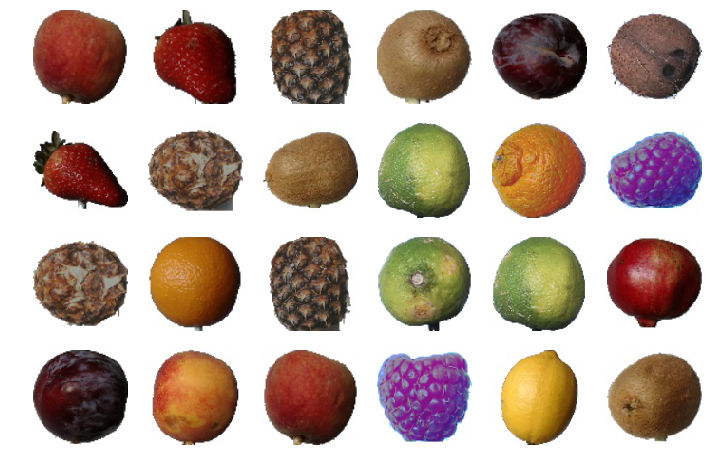

In [18]:
num_beispiel_bilder = 24
beispiel_bilder = random.sample(beispiel_bilder, num_beispiel_bilder)

fig = plt.figure(figsize=(12,8))

for i in range(num_beispiel_bilder):
    fig.add_subplot(4, 6, i + 1)
    plt.axis('off')
    img = plt.imread(beispiel_bilder[i])
    plt.imshow(img)

### Bilder mit Keras einlesen

Um die Bilder einzulesen verwenden wir zwei praktische Funktionen aus `keras`, die genau für den Fall gemacht sind, dass wir Bilder in Unterordnern sortiert haben und die Namen der Unterordner die Klassen-Label darstellen:

- `ImageDataGenerator`: generiert **Batches von Bilddaten**, optional mit Data Augmentation (Multiplizierung und Veränderung der Trainingsbilder). Hier **normalisieren** wir die rohen Pixelwerte, indem wir durch den Maximalwert 255 teilen und so Werte zwischen 0 und 1 erhalten.
- `flow_from_directory`: **liest Bilder aus Dateien** entsprechend dem definierten ein `ImageDataGenerator`, optional mit Skalierung auf eine `target_size`. Lest euch die Hilfe für die Funktion durch (`?train_data_gen.flow_from_directory`), um mehr über die anderen Argumente zu erfahren.

Diese beiden Funktionen wenden wir entsprechend auf Trainings- und Validierungsdaten an (Achtung: Data Augmentation NICHT auf Validierungsdaten anwenden).

Den `ImageDataGenerator` könnten wir auch verwenden, um Kreuzvalidierungsdaten aus nur einem Trainingsset zu definieren. Dafür würden wir das Argument `validation_split` in Kombination mit `flow_from_directory(subset = 'training or validation')` verwenden.

In [19]:
train_data_gen = ImageDataGenerator(
    rescale = 1 / 255
)

valid_data_gen = ImageDataGenerator(
    rescale = 1 / 255
)

train_image_array_gen = train_data_gen.flow_from_directory(
    train_image_files_path,
    target_size = (img_width, img_height),
    class_mode = 'categorical',
    classes = fruit_list,
    color_mode = 'rgb', 
    batch_size = batch_size,
    seed = 42)

valid_image_array_gen = valid_data_gen.flow_from_directory(
    valid_image_files_path,
    target_size = (img_width, img_height),
    class_mode = 'categorical',
    classes = fruit_list,
    color_mode = 'rgb', 
    batch_size = batch_size,
    seed = 42)

Found 7709 images belonging to 16 classes.
Found 2428 images belonging to 16 classes.


### Das Keras-Modell erstellen

In diesem Keras-Beispiel verwenden wir die einfachere sequentielle API (im Gegensatz zur etwas komplexeren aber flexibleren funktionellen API), deshalb müssen wir unser Modell zunächst mit der `Sequential()` Funktion initialisieren.

In [20]:
model = Sequential()

Nach der Input-Schicht, in die unsere Bilder mit ihren Pixel-Arrays eingehen (und die in Keras implizit ist, also nicht speziell definiert werden muss, sondern deren Größe mit `input_shape = (img_width, img_height, channels))` in der ersten versteckten Schicht definiert wird), kommen in der Regel eine oder zwei **Faltungsschichten** (plus **Aktivierungsfunktion** nach jeder Faltung, z.B. Rectified Linear Units `relu`). 

Die erste versteckte Schicht in unserem Keras CNN definieren wir nun mit der `Conv2D()` Funktion.

Der erste Hyperparameter in dieser Funktion ist `filter`. Manchmal werden **Filter** auch als **Kernel** oder Filter Kernel bezeichnet. Tatsächlich sind Filter Sammlungen von Kernels, d.h. wenn wir mit Farbbildern und 3 Kanälen - also 3 Dimensionen - arbeiten, haben wir einen Kernel pro Kanal, aus dem sich ein Filter zusammensetzt. Pro Filter bekommen wir dann EINEN Ergebniswert aus dem Skalarprodukt zurück!

Beispiele für Filter können zum Beispiel das Originalbild verwaschen, untere oder obere horizontale Kanten erkennen. Im Prinzip können aber beliebige Werte in die Filter eingesetzt werden, so dass verschiedenste Muster in dem Bild hervortreten. Jedes Muster stellt eine sogenannte **Feature Map** oder **Activation Map** dar. Die Werte, die an den einzelnen Stellen des Filters stehen, sollen jetzt von unserem neuronalen Netz gelernt werden. Das CNN lernt also, welche Transformation es wann durchführen muss, um die richtigen Muster und Objekte in den Bildern zu erkennen. Dafür lernt das CNN nicht nur einen Filter, sondern sehr sehr viele. Es lernt sogar in jeder versteckten SCHICHT mehrere Filter parallel - in unserer ersten versteckten Schicht haben wir `filters = 32` angegeben, d.h. dass unser CNN in dieser Schicht 32 Filter parallel lernt!

Diese unabhängig voneinander parallel gelernten Filter, bzw. die transformierten Output-Bilder nach der Faltung, produzieren die sogenannten **Stacks of Feature Maps** oder Activation Maps. Die Anzahl der zu trainierenden Parameter ist bei Faltungen deutlich geringer als bei voll verknüpften Neuronen in MLPs. Bei Farbbildern mit 3 Farbkanälen haben wir 3-dimensionale Filter, die das Ergbenis ebenfalls mit dem Skalarprodukt aus Filter und Bildausschnitt berechnen.

Die `kernel_size` definiert die **Größe des Sliding Window** (also hier 3 x 3 Pixel).

**Schrittgröße** `strides` bezeichnet, wie weit das Sliding Window bei jedem Schritt vorrückt. Meisten wird eine Schrittgröße von 1 verwendet, d.h. dass das Sliding Window nach jeder Faltung jeweils einen Pixel weiterwandert - und zwar sowohl von links nach rechts, als auch von oben nach unten (darum `strides = (1, 1)`). Würden wir die Schrittgröße vergrößern, würde die Berechnung des neuronalen Netzes schneller gehen, wir würden aber auch nicht so detaillierte Muster erkennen können. Und unser Bild würde sich im Output verkleinern.

**Padding** bezeichnet das Hinzufügen von extra Pixelschichten am Rand des Bildes, damit jeder Pixel des eigentlichen Bildes beim scannen des Sliding Windows gleich häufig gefaltet wird. Würden wir kein Padding anwenden, würden die Randpixel weniger häufig betrachtet, als die Pixel in der Mitte des Bildes - und unser Bild würde nach der Transformation kleiner werden. Es gibt mehrere Arten von Padding. Bei `padding = "same"` werden die Randpixel dupliziert und an an den Rand hinzugefügt. Alternativ könnten wir die Ränder auch mit Nullern auffüllen, dem sogenannten Zero-Padding.

In [21]:
# first hidden layer
model.add(Conv2D(filters = 32, 
                 kernel_size = (3, 3),
                 strides = (1, 1),
                 padding = "same", 
                 input_shape = (img_width, img_height, channels)))
model.add(Activation('relu'))

In der zweiten versteckten Schicht definieren wir hier eine zweite Faltungsschicht, dieses Mal mit 16 Filtern.

Auch die Aktivierungsfunktion verändern wir hier ein wenig, und zwar mit der **Leaky Rectified Linear Units** Funktion `LeakyReLU`. Normale ReLU-Funktionen können "sterben" wenn wir viele negativen Werte haben, da alle negativen Werte einheitlich auf 0 gesetzt werden und so kein Gradient mehr vorhanden ist. D.h. der Gradient ist ebenfalls 0, und liefert keine Information über den nächsten Schritt in der Optimierung. Bei Leaky ReLU werden auch negative Werte transformiert, so dass dieses Problem nicht mehr auftreten kann.

Außerdem verwenden wir an dieser Stelle **Batch-Normalisierung**, die die Ergebnisse aus der zweiten Faltungsschicht normalisiert. Da jeder Batch eine Approximation der tatsächlichen Verteilung der Daten darstellt, kann es in den Batches leicht zu Veränderungen in der Verteilung kommen. Das kann zu Problemen führen und Batch-Normalisierung kann hier helfen.

In [22]:
# second hidden layer
model.add(Conv2D(16, (3, 3), padding = "same"))
model.add(LeakyReLU(alpha = 0.5))
model.add(BatchNormalization())

CNN-Architekturen bestehen aber nicht nur aus Schichten, in denen Faltung passiert, sondern sie haben zusätzlich sogenannte **Pooling**-Schichten. In den Pooling-Schichten werden die Bilder (also die transformierten Outputs aus vorhergehenden Faltungsschichten) verkleinert. Dafür wird auch wieder ein Sliding Window verwendet, dieses muss nicht die selbe Größe haben, wie das Sliding Window aus den Faltungsschichten, hier verwenden wir `pool_size = (2,2)`. Wichtig ist dabei, dass das Sliding Window beim Pooling meist nicht überlappt, sondern jeder Pixel genau 1x betrachtet wird, damit das Output-Bild entsprechend kleiner wird.

Es gibt mehrere Arten, wie Bilder mit Pooling verkleinert werden können. Die häufigsten sind **Max Pooling**, wo nur der größte Wert jedes Fensters behalten wird, Average Pooling, wo der Durschschnittswert aus jedem Fenster gebildet wird und Sum Pooling, wo die Summe aller Werte gebildet wird. Hier verwendet wir `MaxPooling2D` plus `Dropout` (zufällige Inaktivierung von 25% der Neuronen). Pooling arbeitet dabei unabhängig auf jeder einzelnen Feature Map und sorgt nicht nur für eine Reduktion des Bildes und damit an zu optimierenden Parametern, sondern hilft auch dabei, allgemeingültige Feature zu extrahieren, die robust gegenüber kleineren Änderungen des Inputs sind.

In [23]:
# max pooling
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

Bevor wir das Endergbnis, zum Beispiel eine Klasse bestimmen lassen, folgt ein **Dense-Layer** mit 512 Knoten (`Dense(512)`), als würden wir ein kleines MLP hinten dran hängen. Damit unsere multidimensionalen Filter in den Dense-Layer übergehen können, müssen wir die Daten erst "`Flatten()`". Im Dense-Layer werden deshab wieder Gewichte gelernt. Im Wesentlichen haben die Faltungsschichten in unserem Netz relevante Feature gefunden, und die Pooling-Schichten habe diese Information soweit verdichtet, dass es nun sinnvoll ist ein MLP zu trainieren, dass in der Lage ist die finale Klassifikation zu lernen.

Und zuletzt haben wir eine **Output-Schicht** mit der Anzahl der möglichen Klassen (`Dense(output_n)`) und die Softmax Aktivierungsfunktion, ebenfalls wie bei einem einfachen MLP.

In [24]:
# Flatten max filtered output into feature vector 
# and feed into dense layer
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# Outputs from dense layer are projected onto output layer
model.add(Dense(output_n))
model.add(Activation('softmax'))

In [25]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 20, 20, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 20, 20, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 16)        4624      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 20, 20, 16)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 20, 20, 16)        64        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 10, 16)        0         
__________

Später werden wir die Anzahl der Trainings- und Validierungsbilder benötigen. Damit wir leicht damit arbeiten können, definieren wir diese Zahlen hier als Objekte:

In [26]:
train_samples = train_image_array_gen.n
valid_samples = valid_image_array_gen.n

Nachdem wir das neuronale Netz wie oben beschrieben definiert haben, müssen wir es **kompilieren**. Dafür geben wir die folgenden drei Argumente an:

- `loss`: die zu minimierende [Loss-Funktion](https://keras.io/losses/), hier kategorische Kreuzentropie
- `optimizer`: [Optimierungsfunktion](https://keras.io/optimizers/), hier RMSprop, eine ähnliche Technik wie Gradient Descent mit Momentum
- `metrics`: [Performance-Metrik(en)](https://keras.io/metrics/)

In [27]:
model.compile(loss = 'categorical_crossentropy', 
              optimizer = RMSprop(lr = 0.0001, decay = 1e-6),
              metrics = ['accuracy'])

Nun kann das Modell trainiert werden. Da wir unsere Daten mit dem ImageDataGenerator einlesen wollen, verwenden wir hier analog die `fit_generator` Funktion und geben die Trainingsdaten, Validierungsdaten, Anzahl der Epochen und die Anzahl der Schritte (`steps_per_epoch`) an, um die Anzahl der einzulesenen Bilder pro Batch zu definieren.

In [28]:
history = model.fit_generator(
    train_image_array_gen,
    steps_per_epoch = int(train_samples / batch_size), 
    epochs = epochs, 
    validation_data = valid_image_array_gen,
    validation_steps = int(valid_samples / batch_size),
    verbose = 1
)

Epoch 1/5
240/240 [==============================] - 94s 391ms/step - loss: 1.0245 - acc: 0.6865 - val_loss: 0.2216 - val_acc: 0.9371
Epoch 2/5
240/240 [==============================] - 66s 275ms/step - loss: 0.1604 - acc: 0.9514 - val_loss: 0.0361 - val_acc: 0.9954
Epoch 3/5
240/240 [==============================] - 67s 278ms/step - loss: 0.0602 - acc: 0.9822 - val_loss: 0.0154 - val_acc: 0.9950
Epoch 4/5
240/240 [==============================] - 67s 277ms/step - loss: 0.0273 - acc: 0.9922 - val_loss: 0.0106 - val_acc: 0.9967
Epoch 5/5
240/240 [==============================] - 70s 292ms/step - loss: 0.0139 - acc: 0.9970 - val_loss: 0.0130 - val_acc: 0.9967


In [29]:
# list all data in history
print(history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


Der Output während des Trainings gibt uns schon einen Überblick über die Entwicklung der Performance-Metrik auf Trainings- und Validierungsdaten in den einzelnen Epochen. Wir können das ganze aber auch mit Matplotlib plotten:

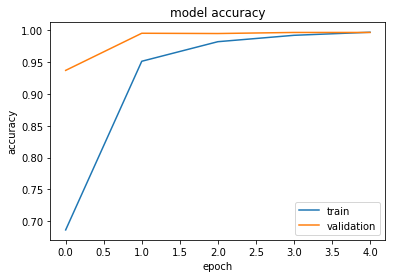

In [30]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc = 'lower right')
plt.show()

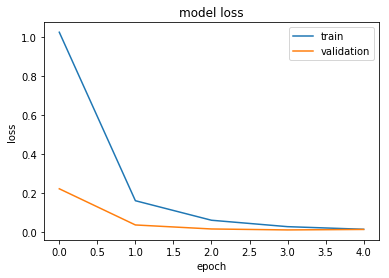

In [31]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc = 'upper right')
plt.show()

### Vorhersage auf Testdaten

Und letztendlich können wir das so trainierte Modell nun für Vorhersagen auf neuen Testdaten verwenden, z.B. auf diesem Bild einer Banane, das von Wikipedia heruntergeladen wird:

Das heruntergeladene Testbild ist im Ordner `test_images` gespeichert und kann entweder mit dem ImageDataGenerator eingelesen werden (macht vor allem Sinn, wenn wir viele Testbilder haben) oder wie folgt:

In [32]:
test_image_files_path = "test_images/"

In [33]:
test_images = !find $test_image_files_path -type f -name "*.jpg"

Bevor wir Vorhersagen mit unserem Modell machen, definieren wir noch eine Liste mit den Klassen-Indizes, denn Keras wird uns keine Label im Sinne von Strings mit den Namen der Früchte zurück geben sondern Indizes.

In [34]:
classes = train_image_array_gen.class_indices
classes

{'Kiwi': 0,
 'Banana': 1,
 'Apricot': 2,
 'Avocado': 3,
 'Cocos': 4,
 'Clementine': 5,
 'Mandarine': 6,
 'Orange': 7,
 'Limes': 8,
 'Lemon': 9,
 'Peach': 10,
 'Plum': 11,
 'Raspberry': 12,
 'Strawberry': 13,
 'Pineapple': 14,
 'Pomegranate': 15}

Nun können wir alles für die Vorhersage in eine Funktion verpacken, die

- das zu klassifizierende Bild einliest,
- plottet,
- in die richtigen Dimensionen für Keras bringt (da Keras immer eine Batch-Dimension erwartet, fügen wir diese mit der `expand_dims` Funktion hinzu),
- skaliert
- und schließlich klassifiziert.

Die eigentliche Klassifikation erfolgt mit der `predict` Funktion.

In [35]:
def classify_image_model(image, classes=classes):
    img = cv2.imread(image)        
    b,g,r = cv2.split(img)       # get b,g,r
    img = cv2.merge([r,g,b])     # switch it to rgb
    plt.imshow(img)
    plt.xticks([]), plt.yticks([])
    plt.show()
    
    image = image_utils.load_img(image, target_size=(img_width, img_height))
    image = image_utils.img_to_array(image)

    image = np.expand_dims(image, axis=0)

    # scale pixels between 0 and 1, sample-wise
    image /= 255.
        
    prediction = model.predict(image)
    
    pred = prediction.argmax()

    for k, v in classes.items():
        if (v == pred):
            pred_label = k
        
    proba = prediction.max()
    
    print("Predicted class: " + pred_label + " with probability " + str(proba*100) + "%")

Wenden wir unsere Vorhersagefunktion also auf das Testbild an:

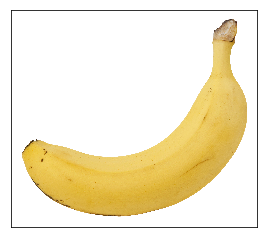

Predicted class: Banana with probability 99.99998807907104%


In [36]:
classify_image_model(test_images[0])

Unser Modell liegt richtig!

Noch ein Hinweis zum Abschluss: Wir könnten Testbilder auch mit `predict_generator()` und `evaluate_generator()` vorhersagen/bewerten. Das ist hier nicht gezeigt, kann aber einfach analog zu den Trainingsdaten mit `ImageDataGenerator` und `flow_from_directory` implementiert werden - geändert werden müsste dafür `class_mode = 'categorical'` in `class_mode = 'None'`.